<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("error")
import logging

0.06666666666666667
|██████████| 100.0% |█████| 100.0%

0.1
|██████████| 100.0% |█████| 100.0%

0.125
|██████████| 100.0% |█████| 100.0%

0.16666666666666666
|██████████| 100.0% |█████| 100.0%



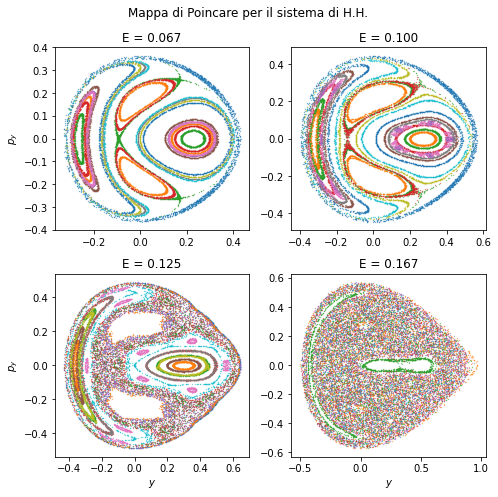

In [12]:
def my_integrator(t, init):
    """Definisco un Eulero al secondo ordine"""
    n = len(t)
    dt = t[1]-t[0]
    x = init[0]*np.ones(n) 
    y = init[1]*np.ones(n)
    px = init[2]*np.ones(n)
    py = init[3]*np.ones(n)
    x = np.array([x, y, px, py])
    for i in range(n-1):
        x_aux = x[:,i] + np.array(motion(t, x[:,i]))*dt
        x[:,i+1] = 1/2*(x_aux + x[:,i] + np.array(motion(t, x_aux))*dt)
    return x

def motion(t, val):
    """
    Questa funzione definisce gli incrementi secondo il formato utile a 'solve_ivp' di scykit_learn.
    """
    x, y, px, py = val
    diff = [px,
            py,
            - x - 2 * x * y,
            - y - x**2 + y**2]
    return diff

def energy(J1, J2, phi1, phi2, alfa):
    """L'hamiltoninana: per valutare l'energia"""
    return 1/2 * (px**2 + py**2) + 1/2*(x**2 + y**2) + x**2 * y - 1/3 * y**3

def eval_px(x, y, py, E):
    return np.sqrt(2 * ( E - 1/2*(x**2 + y**2) - x**2 * y + 1/3 * y**3 - py**2/2 ))

def eval_x(y, py, E):
    a = py**2/2 + 1/2 * y**2 + 1/3 * y**3 - E 
    b = y - 1/2 
    return np.sqrt(a/b)
    
    
def solver_eulero(t, init):
    """
    Questa funzione calcola l'intera evoluzione temporale delle J,phi facendo l'integrazione con my_integrator (qui può essere sostituito il solver 
    commentato in fondo), inoltre fa la trasformazione canonica per ottenere py, y.
    """
    #x_in, y_in, px_in, py_in = init
    sol = my_integrator(t, init)
    x, y, px, py = sol # (come scrivere sol[0,:], sol[1,:], sol[2,:], sol[3,:])
    return x, y, px, py

def solver_ivp(t, init):
    """
    Funzione alternativa a solver_eulero
    """
    sol = solve_ivp(motion, [t[0], t[-1]], init, t_eval=t, method='Radau')
    x = sol.y[0,:]
    y = sol.y[1,:]
    px = sol.y[2,:]
    py = sol.y[3,:]
    return x, y, px, py

def crossing_zero(x, y, px, py):
    dt = 1e-6
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    y_i, py_i = y[zero_crossings], py[zero_crossings]
    x_i, px_i =x[zero_crossings], px[zero_crossings]
    after_cross=zero_crossings+1
    y_f, py_f = y[after_cross], py[after_cross]
    x_f, px_f =x[after_cross], px[after_cross]
    # print(f'Plotto {len(y[zero_crossings])} punti\n')
    return (y[zero_crossings] + y[after_cross])/2, (py[zero_crossings] + py[after_cross])/2

def main():
    """
    Funzione main: fa da collante per tutte le funzioni sopra e inoltre plotta i risultati.
    """
    fig, ax = plt.subplots(2, 2 , figsize=(7,7))
    # Energia e parametro della perturbazione
    energies = [1/15, 1/10, 1/8, 1/6]
    #E = 1/15
    #E = 1/10
    #E = 1/8
    #E = 1/6
    j = 0
    k = 0
    for i, E in enumerate(energies):
        print(E)
        if i == 2: 
            j = 0
            k = 1
        py_max = np.sqrt(2 * E) # Fisso py in modo da non rompere tutto
        py_initials = [py_max - py_max * i/4 for i in range(0,5)] # Fisso dei py ragionevoli      
        y_initials = [-0.3, -0.15,-0.00355, 0, 0.15, 0.3] # seleziono anche un set di y ragionevoli
        
        lim_loop = len(py_initials) - 1 # ABBELLIMENTO
        lim_loop1 = len(y_initials) - 1 # ABBELLIMENTO
        # y_initials = np.arange(-0.005, -0.002, 0.0002) # Per trovare il punto fisso
        
        for s, py_in in enumerate(py_initials):
            #### BEG BELLUIRE
            cage = np.floor(10*s/lim_loop)
            percentage = np.floor(100*s/lim_loop)
            big_perc_string = '|' + chr(9608)*int(cage) + '#'*int(10-cage) + '| ' + f'{percentage}' + '%'
            #### END BELLUIRE
            
            for m, y_in in enumerate(y_initials):
                #### BEG BELLUIRE
                cage1 = np.floor(5*m/lim_loop1)
                little_perc_string = '|' + chr(9608)*int(cage1) + '#'*int(5-cage1) + '| '
                print(big_perc_string + ' ' + little_perc_string, end="\r")
                #### END BELLUIRE
                try: # Se da errore si ferma e passa al prossimo loop
                    t = np.linspace(0, 5001, 10000001) # Intervallo temporale valutato

                    # Valuto le condizioni iniziali su x
                    x_in = eval_x(y_in, py_in, E)
                    px_in = eval_px(x_in, y_in, py_in, E)
                    init = [x_in, y_in, px_in, py_in]
                    
                    # Moto effettivo
                    x, y, px, py = solver_ivp(t, init)
                    
                    # Valuto l'attraversamento del piano x = 0
                    y, py = crossing_zero(x, y, px, py)
                    
                    # Plotto i risultati
                    ax[k][j].scatter(y, py, label=fr'$p_y$ = {py_in:.2f}, y = {y_in}', s = 0.1, alpha=0.8)
                    ax[k][j].set_title(f'E = {E:.3f}')
                    if j == 0:
                        ax[k][j].set_ylabel(r'$p_y$')
                    if k == 1:
                        ax[k][j].set_xlabel(r'$y$')
                except RuntimeWarning as e: # Se avviene il runtimeWarning non fa nulla e stampa l'errore
                    pass
                    #print(f'Errore: {e}\n')
                    #logging.exception("An exception was thrown!") 
        print('\n')
        j += 1

#     plt.grid(alpha=0.3)
    fig.suptitle('Mappa di Poincare per il sistema di H.H.')
    plt.tight_layout()
#   plt.savefig('../../figures/18_Henon-Heiles.png', dpi = 300)
    plt.show()
main()